In [ ]:
# local에 padnas, numpy, matplotlib 설치필요
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# local에 pyspark 설치필요
!pip install pyspark
import pyspark
from pyspark.sql.types import StructField, StructType, StringType, DoubleType, FloatType, IntegerType
from pyspark.sql.functions import col, count
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from sklearn.metrics.pairwise import cosine_similarity

# # Spark 세션 생성
spark = SparkSession.builder \
    .appName("RS_AmazonXTwitter") \
    .getOrCreate()

# 1. Amazon Data

**1-1. Used Data**

*   https://amazon-reviews-2023.github.io/






# Colaborative Filtering


In [95]:
def preprocess_review(review_path):
    try:
        # JSON 데이터 읽기
        review_df = spark.read.json(review_path)
        # 데이터 필터링
        filtered_review_df = review_df.select("asin", "rating", "user_id", "title")
        filtered_review_df = filtered_review_df.withColumn("rating", col("rating").cast(FloatType()))
        # 데이터 타입 강제 변환
        # filtered_review_df = filtered_review_df \
        #     .withColumn("rating", col("rating").cast(FloatType()))
        # print("Schema after casting rating to Float:")
        # filtered_review_df.printSchema()

        # 유효한 데이터 필터링
        # filtered_review_df = filtered_review_df.filter(
        #     col("asin").isNotNull() &
        #     col("rating").isNotNull() &
        #     col("user_id").isNotNull()
        # )

        # # 스키마 강제 적용
        # review_schema = StructType([
        #     StructField("asin", StringType(), False),
        #     StructField("rating", FloatType(), False),
        #     StructField("user_id", StringType(), False),
        # ])
        # review_df = spark.createDataFrame(filtered_review_df.rdd, schema=review_schema)
        return filtered_review_df
    except Exception as e:
        print(f"Error in preprocess_review: {e}")
        raise

def sort_review(review_df):
  # Step 1: _asin과 user_id 조합의 중복 제거
  distinct_review_df = review_df.dropDuplicates(["user_id", "asin"])
  sorted_review_df = distinct_review_df

#   # Step 2: user_id 빈도 계산
#   user_id_count_df = distinct_review_df \
#       .groupBy("user_id") \
#       .agg(count("user_id").alias("user_id_count"))

#   # Step 3: 중복 제거된 데이터와 user_id_count 병합
#   sorted_review_df = distinct_review_df \
#       .join(user_id_count_df, on="user_id") \
#       .orderBy(col("user_id_count").desc(), col("user_id").asc()) # user_id_count 내림차순, user_id 오름차순

#   # Step 4: 정렬된 데이터에서 user_id_count 제거 (필요하면)
#   sorted_review_df = sorted_review_df.drop("user_id_count")
  return sorted_review_df



In [96]:
def CF_review(review_df):
    popular_items = review_df.groupBy("asin").agg(count("user_id").alias("num_reviews"))
    popular_items = popular_items.orderBy(col("num_reviews").desc())

    # 상위 n개의 인기 아이템 추출
    popular_item_asins = [row["asin"] for row in popular_items.limit(5000).collect()]

    # 인기 아이템을 포함한 데이터 필터링
    sampled_reviews = review_df.filter(col("asin").isin(popular_item_asins))

    sampled_df = sampled_reviews.limit(10000)  # 전체 데이터에서 10% 랜덤 샘플링 (최대 10000개)
    # 3. 유저-아이템 pivot 테이블 생성
    pivot_df = sampled_df.groupBy("asin").pivot("user_id").agg({"rating": "first"})
    pivot_df = pivot_df.fillna(0)

    # PySpark DataFrame -> Pandas DataFrame 변환
    pivot_pandas = pivot_df.toPandas()

    # 'asin' 컬럼 제거 (필요한 경우)
    pivot_pandas = pivot_pandas.set_index("asin")

    # Null 값을 0으로 대체 (cosine_similarity는 NaN 값을 허용하지 않음)
    pivot_pandas = pivot_pandas.fillna(0)

    # Pandas DataFrame -> NumPy 배열 변환
    pivot_numpy = pivot_pandas.values

    # 4. 코사인 유사도 계산
    similarity_score = cosine_similarity(pivot_numpy)

    # 결과 출력
    print("Similarity Score Shape:", similarity_score.shape)

    return {"pivot_pandas": pivot_pandas, "similarity_score": similarity_score}

def recommend_items(target_index, similarity_score, pivot_pandas, top_n=5):
    similarities = similarity_score[target_index]
    similar_items = sorted(enumerate(similarities), key=lambda x: x[1], reverse=True)[1:top_n+1]
    recommendations = [(pivot_pandas.index[i], score) for i, score in similar_items]
    return recommendations

In [97]:
review_path = os.path.abspath("./amazon_review/Baby_Products_50K.json")
review = preprocess_review(review_path)
sorted_review = sort_review(review)

unique_asins_df = review.select("asin").distinct()

# # 결과 확인
unique_asins_df.show()
sorted_review.show()

+----------+
|      asin|
+----------+
|B08M2DN7J9|
|B0743M24KF|
|B00GJY6EPG|
|B079H8S5TK|
|B0BHY8J7DF|
|B09W9MRP7T|
|B0918D3FYM|
|B08WCPBCCN|
|B083W6SWYC|
|B08D1TBBP4|
|B07X2S2D4F|
|B09C1BZPZV|
|B01LWSSEVH|
|B01049VXFM|
|B00FFJ3TJA|
|B07VHG51YJ|
|B01IL2F3HI|
|B07985Z8YN|
|B08HDTFLC4|
|B08V1KZY26|
+----------+
only showing top 20 rows

+----------+------+--------------------+--------------------+
|      asin|rating|             user_id|               title|
+----------+------+--------------------+--------------------+
|B00O2VRLWI|   3.0|AE22BZ4I2434QRWLO...|Ahhhhhhh...Not So...|
|B00L378RZY|   5.0|AE22JH5VGRWT6ABCF...|... this crib fro...|
|B005IWM9AO|   5.0|AE22PJ54OVIRX3I6K...|Works well for ou...|
|B07D2G6CLG|   4.0|AE22Z3RLVIRU6RT5P...|       KUDOS JOHNSON|
|B07H8N7KZ8|   5.0|AE23353TWZHXV74H7...|       Very pleased!|
|B0028H3ACS|   5.0|AE23ZLT2QYU6NIHTB...|     Perfect soother|
|B00I0NKH7K|   5.0|AE23ZLT2QYU6NIHTB...|       Fits a Chicco|
|B00KBGTRAC|   5.0|AE23ZLT2QYU6NIHTB...|  

In [98]:
cf_review = CF_review(sorted_review)
pivot_pandas = cf_review["pivot_pandas"]
similarity_score = cf_review["similarity_score"]

Similarity Score Shape: (4104, 4104)


In [99]:
print("Shape of similarity_score:", similarity_score.shape)
print("Max similarity:", similarity_score.max())
print("Min similarity:", similarity_score.min())
print("Mean similarity:", similarity_score.mean())

Shape of similarity_score: (4104, 4104)
Max similarity: 1.0000002
Min similarity: 0.0
Mean similarity: 0.0039760307


In [108]:
target_index = 0  # 첫 번째 아이템의 인덱스
similarities = similarity_score[target_index]
print("Similarities for item at index 0:", similarities)

# 상위 5개의 가장 유사한 아이템 (자기 자신 제외)
similar_items = sorted(enumerate(similarities), key=lambda x: x[1], reverse=True)[1:6]
print("Top 5 similar items:", similar_items)

Similarities for item at index 0: [1.0000001 0.        0.        ... 0.        0.        0.       ]
Top 5 similar items: [(2280, 0.5883484), (1130, 0.5547002), (89, 0.41602516), (351, 0.40794623), (1642, 0.30769232)]


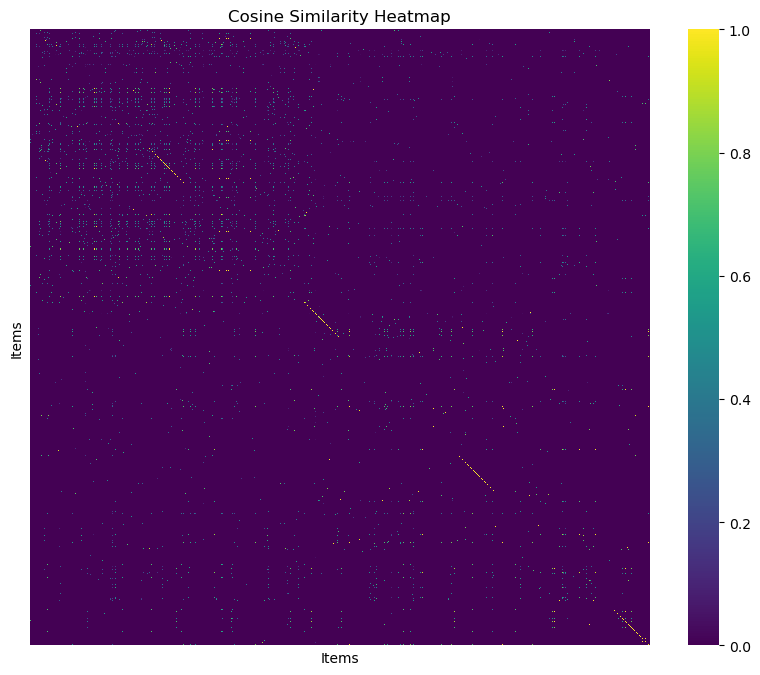

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_score, cmap="viridis", xticklabels=False, yticklabels=False)
plt.title("Cosine Similarity Heatmap")
plt.xlabel("Items")
plt.ylabel("Items")
plt.show()

In [109]:
recommendations = recommend_items(0, similarity_score, pivot_pandas)

target_asin = pivot_pandas.index[0]

print(f"Recommendations for item {target_asin}:", recommendations)

Recommendations for item B075Q21NDJ: [('B01MXZX45V', 0.5883484), ('B07TBPK7P2', 0.5547002), ('B01CJABFL6', 0.41602516), ('B000V44B4G', 0.40794623), ('B00M0DWQYI', 0.30769232)]
